In [1]:
# import pandas and matplotlib
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# import SQLalchemy create_engine, automap_base, session
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy import distinct


In [3]:
import datetime as dt

# Hawaii trip period
* Start date - 2017/07/08
* End data - 2017/07/15

In [4]:
# create engine for the hawaii.sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# use inpector to explore database and print table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# use inpector to print column names and types for measurement
columns_m = inspector.get_columns('measurement')
for column in columns_m:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# refelct database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# start session to query the database
session = Session(engine)

In [9]:
# create variable to hold the query values for date and preciptation,
# last 12 months of data from the begining of my trip 2017/07/15

# create and store variables for start and end dates of the trip
start = dt.date(2017, 7, 8)
end = dt.date(2017, 7, 15)

# convert the datetime object into string to match the dateset format
first_day = start.strftime('%Y-%m-%d')
last_day = end.strftime('%Y-%m-%d')

# calculate the date 12 months before the trip start date
# to use as query date range
query_start = dt.date(2017, 7, 8) - dt.timedelta(365)
query_end = dt.date(2017, 7, 15) - dt.timedelta(365)

# convert datete into string  to match the dateset format 
query_start_date = query_start.strftime('%Y-%m-%d')
query_end_date = query_end.strftime('%Y-%m-%d')



In [10]:
'''
query the precipition for the 12 months previous to the date start date
we will query date and prcp from the Measurement table
set the filter into to the date as starting on query start date
group by the dates
'''

query_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_start_date).\
    filter(Measurement.date < first_day).\
    group_by(Measurement.date).all()


In [11]:
# load the results from the variable created into Pandas dataframe 
measurement_df = pd.DataFrame(query_precipitation)
# set index on date
measurement_df.set_index('date', inplace=True)
# sort values by date
measurement_df.sort_values(by='date')
# rename prcp to Precipitation for readability
measurement = measurement_df.rename(columns={"prcp":"Precipitation"})
# clean data by dropping any NA value
measurement_results = measurement.dropna()
# now that the dataframe is sorted by date, reset index to use dates as a list to plot
measurement_reset_index = measurement_results.reset_index()

measurement_reset_index.head()

,date,Precipitation
0,2016-07-08,0.31
1,2016-07-09,0.15
2,2016-07-10,1.15
3,2016-07-11,0.11
4,2016-07-12,0.03


## Precipitation Analysis

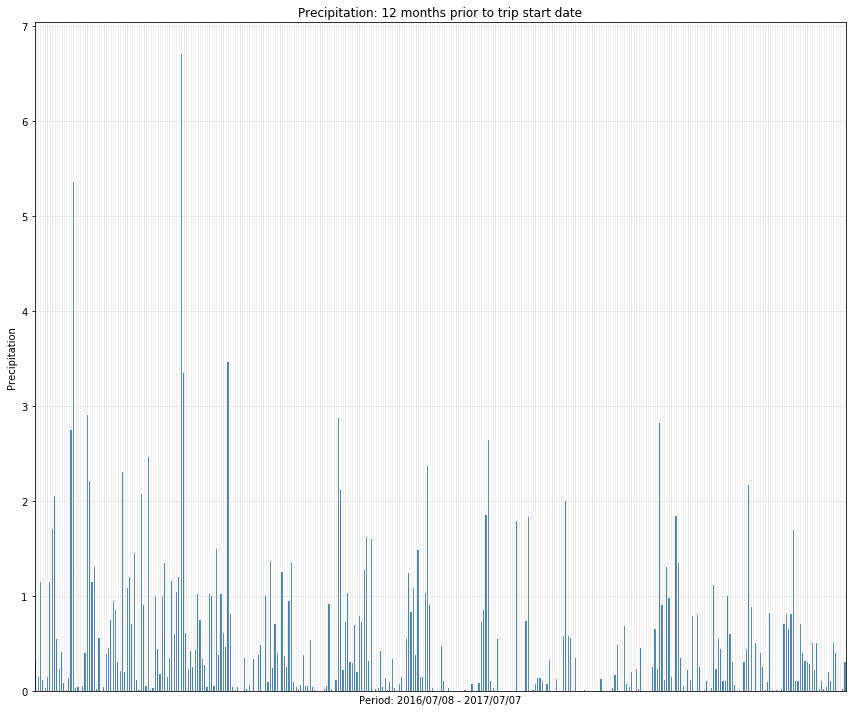

In [12]:
# plot using the dataframe created from the query as a bar chart
measurement_reset_index['Precipitation'].plot(kind='bar', figsize=(12, 10), title='Precipitation',color='steelblue')
# set y lable
plt.ylabel("Precipitation")
plt.xlabel("Period: 2016/07/08 - 2017/07/07")
# set grid and its transparence
plt.grid(alpha=0.25)

# remove xticks, since there are too many ticks, the ticks are on top of each other
# and not really readable, so it looks better without each date printed
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# set title
plt.title("Precipitation: 12 months prior to trip start date")
plt.tight_layout()
# save image
plt.savefig("Resources/precipitaion.png")
plt.show()

### Precipitation Statistical Summary

In [13]:
measurement_reset_index.describe()

,Precipitation
count,346.000000
mean,0.479017
std,0.766550
min,0.000000
25%,0.010000
50%,0.150000
75%,0.687500
max,6.700000


## Station Analysis

In [14]:
# use inpector to print column names and types for station table
columns_s = inspector.get_columns('station')
for column in columns_s:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


#### Total number of Stations

In [15]:
# counts the number os stations available in this dataset
query_stations = session.query(func.distinct(Measurement.station)).count()
print(query_stations)

9


#### Most active stations in descending order

In [16]:
'''
finds the most active stations in descending order
query station into the Measurement table, use func to count the stations appearaces
add label in case we need to convert into pandas dataframe
groupby station and order by the count of station appearances
'''
active_stations = session.query((Measurement.station),\
    func.count(Measurement.station).label("Station_Activity")).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### The Station with highest number of observations is
## station: USC00519281 with 2772 observations

#### Most active station's lowest, highest and average temperatures

In [17]:
'''
most active station (USC00519281)lowest temperature, highest temperature and average temp
query using the func to find min, max and avg temperatures for the most acitve station
setting labels in case we need to convert into pandas dataframe
filter by the station id
'''
most_active_station = session.query(func.min(Measurement.tobs).label('lowest_temp'),\
                      func.max(Measurement.tobs).label('highest_temp'),\
                      func.avg(Measurement.tobs).label('average_temp')).\
                      filter(Measurement.station == "USC00519281").all()

most_active_station

[(54.0, 85.0, 71.66378066378067)]

 ###### Top Station tobs for the 12 months prior to the trip

In [18]:
'''
find out which station the the highest amount of temperature observations
during the 12 months prior to the trip start date
query the station, count the stations appearances
filter by query start date (that is 12 months before the trip start date)
filter by the end date as well to keep it within the range
groupby station and order by the stations count from highest to low
there were two station with the highest count, pick the same one that also 
had the highest count of activities
'''

tobs_last_12months = session.query(Measurement.station,\
    func.count(Measurement.tobs).label("Highest_number_observations")).\
    filter(Measurement.date > query_start_date).\
    filter(Measurement.date < last_day).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
tobs_last_12months

[('USC00513117', 371),
 ('USC00519281', 371),
 ('USC00519397', 369),
 ('USC00516128', 353),
 ('USC00519523', 345),
 ('USC00514830', 303),
 ('USC00517948', 200)]

In [19]:
'''
get all the data from the top station only, set query to temperatures only
filter by query start date and end date and also by the station with highest
tobs counts
'''
top_station_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= query_start_date).\
    filter(Measurement.date <= last_day).\
    filter(Measurement.station == 'USC00519281').all()

In [20]:
# put the date into a Pandas dataframe to plot the histogram
top_station_tobs_df = pd.DataFrame(top_station_tobs)
top_station_tobs_df.head()

,tobs
0,78.0
1,80.0
2,72.0
3,79.0
4,80.0


#### Histogram (Tobs for the  Top Station in the last 12 months)

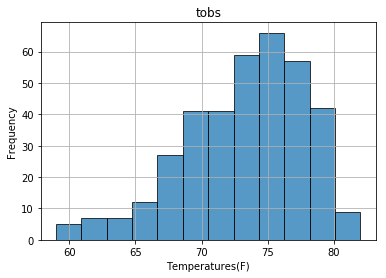

In [21]:
# using the top station dataframe, plot the histogram
hist = top_station_tobs_df.hist(bins=12,edgecolor='black',alpha=0.75)

plt.xlabel('Temperatures(F)')
plt.ylabel('Frequency')
plt.savefig("Resources/histogram")
plt.show()

## Temperature Analysis

In [22]:
'''
create function to measure min, max and avg temperature for a range of date
first select the query items, in this case we are finding the min, max and avg
using func. we filter using start_date and end_date and the paramenter of the function
we can then call the function with any dates we desire to query
'''
def calc_temps(start_date, end_date):
    
   
    sel = [func.min(Measurement.tobs).label('min_temp'),\
           func.max(Measurement.tobs).label('max_temp'),\
           func.avg(Measurement.tobs).label('avg_temp')]
    
    return session.query(*sel).\
           filter(Measurement.date >= start_date).\
           filter(Measurement.date <= end_date).all()

calc_temps(first_day, last_day)

[(69.0, 82.0, 78.3076923076923)]

In [23]:
'''to use to function created above, we just need to call the query start and
end date created earlier'''


calc_temps(query_start_date, query_end_date)

[(71.0, 82.0, 77.26415094339623)]

### Plot Trip Average Temperature

In [24]:
'''
store results from function above into a pandas dataframe
using a loop, get the difference between the max temp and min temp
unpack into a list called ptps to plot as the yerr
'''
previous_year_temps = pd.DataFrame(calc_temps(query_start_date, query_end_date))

results = []
for temp in previous_year_temps:
    diff = (previous_year_temps['max_temp'])-(previous_year_temps['min_temp'])
results.append(diff)

ptps = list(np.ravel(results))


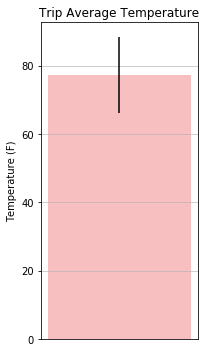

In [25]:
# create subplot
fig, ax = plt.subplots(figsize=(3, 5))

# set x value 
x = np.arange(len(previous_year_temps['avg_temp']))
# plot x as x value and avg temp as y value 
ax.bar(x, previous_year_temps['avg_temp'], yerr=ptps, color='lightcoral', alpha=0.5)

ax.set_title('Trip Average Temperature')
ax.set_ylabel('Temperature (F)')

# remove xtick 
ax.yaxis.grid(alpha=0.75)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tight_layout()
plt.savefig("Resources/trip_avg_temp.png")
plt.show()


### Average Rainfall per Weather Station

In [26]:
'''
list all stations by descending order of  average rainfal for the period of the trip
12 months prior, create a funcion with the query of both tables (Measurement and Station)
using a joing, and func for average precipitation
'''
def rainfall_station(start_date, end_date):
    
    
    sel = [Stations.name, Stations.latitude, Stations.longitude, Stations.elevation,\
          func.avg(Measurement.prcp)]  
    
    return session.query(*sel).filter(Measurement.station == Stations.station).\
                      filter(Measurement.date >= start_date).\
                      filter(Measurement.date <= end_date).\
                      group_by(Measurement.station).\
                      order_by(func.avg(Measurement.prcp).desc()).all()
rainfall_station(query_start_date, query_end_date)
 

[('MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.5925),
 ('WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.22999999999999998),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.145),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.1325),
 ('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13125),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.060000000000000005),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

### Daily Normals


In [27]:
'''
Create a function to calculate the daily normals using a query with the parameter date
being only the month and day of all years in the dateset
''' 

def daily_normals(date):
    
    sel = [func.min(Measurement.tobs).label('min_temp'),\
           func.avg(Measurement.tobs).label('avg_temp'),\
           func.max(Measurement.tobs).label('max_temp')]
    
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_normals= dt.date(2016, 7, 8)
end_normals = dt.date(2016, 7, 16) #had to add an extra day to show correct end date in the range

# Use the start and end date to create a range of dates
range_dates = np.arange(start_normals, end_normals)
range_dates_dt= pd.to_datetime(range_dates)


# Strip off the year and save a list of %m-%d strings
month_days = range_dates_dt.strftime('%m-%d')


# Loop through the list of %m-%d strings and calculate the normals for each date
# calling in the function daily_normals created above
for date in month_days:
    normal = daily_normals(date)
    normals.append(normal)
normals

[[(69.0, 76.08333333333333, 83.0)],
 [(68.0, 76.19298245614036, 83.0)],
 [(68.0, 75.62068965517241, 82.0)],
 [(70.0, 75.78947368421052, 81.0)],
 [(67.0, 75.96491228070175, 82.0)],
 [(69.0, 76.1896551724138, 81.0)],
 [(61.0, 76.2280701754386, 82.0)],
 [(68.0, 76.2542372881356, 82.0)]]

In [29]:
# Load the previous query results into a Pandas DataFrame
normals_df = pd.DataFrame(normals)
# had to set the dataframe to series to strip each value in a separate column
normals_org = normals_df[0].apply(pd.Series)
# add columns trip_date as to hold the month_days list created from the loop
normals_org['trip_dates'] = month_days
# renamed columns
normals_renamed = normals_org.rename(columns={0:'Tmin',1:'Tavg',2:'Tmax'})
# set index to trip dates
normals_renamed.set_index('trip_dates')


,Tmin,Tavg,Tmax
trip_dates,,,
07-08,69.0,76.083333,83.0
07-09,68.0,76.192982,83.0
07-10,68.0,75.620690,82.0
07-11,70.0,75.789474,81.0
07-12,67.0,75.964912,82.0
07-13,69.0,76.189655,81.0
07-14,61.0,76.228070,82.0
07-15,68.0,76.254237,82.0


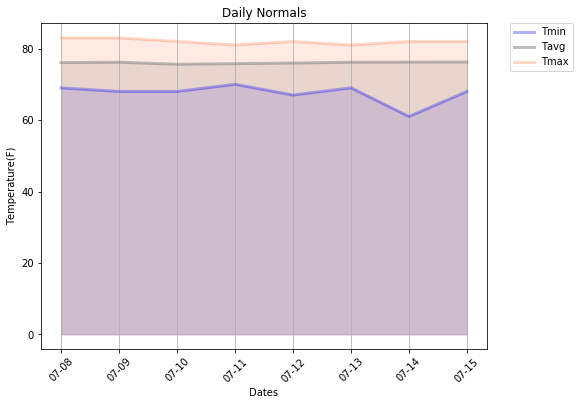

In [30]:
# Plot the daily normals as an area plot
# set variable for each area plot
tmin = normals_renamed['Tmin']
tavg = normals_renamed['Tavg']
tmax = normals_renamed['Tmax']
# x_axis will be the trip_dates for all plots
x_axis = np.arange(len(normals_renamed['trip_dates']))

# plot the area plot with the three variables
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(tmin, label='Tmin',linewidth=3,color='blue',alpha=0.3 )
ax.plot(tavg, label='Tavg',linewidth=3,color='grey',alpha=0.5)
ax.plot(tmax, label='Tmax',linewidth=3,color='coral',alpha=0.3)
# add fill to each plot
ax.fill_between(np.arange(len(tmin)), tmin, color='blue', alpha=0.15)
ax.fill_between(np.arange(len(tavg)), tavg, color='grey', alpha=0.2)
ax.fill_between(np.arange(len(tmax)), tmax, color='coral', alpha=0.15)

# set ticks 
ax.xaxis.set_ticks(np.arange(len(normals_renamed['trip_dates'])))
ax.set_xticklabels(normals_renamed['trip_dates'],rotation=45)

ax.xaxis.grid(alpha=1)

plt.title("Daily Normals")
plt.xlabel("Dates")
plt.ylabel("Temperature(F)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("Resources/daily_normals")
plt.show()


